In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [3]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [4]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [5]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [6]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [7]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [8]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [9]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 2000)

In [10]:
# 첫번째 행 제거
data = data.drop(0)

In [11]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [12]:
data[:10]

,comment,label
0,무개념 개티즌들이 망친 평점 다시올라가길.,0
1,'일본이 모든 음식의 기원한 곳이라고 한거 너잔아 씨발년아',2
2,"윤여정의 새로운 발견,,,코를 징끗하며 ,, 타고난 연기의 화신",0
3,트럼프 존나젊어보이네 나홀로집에2 나오던때냐,2
4,겁나 재밌어요 짱짱짱ㅋㅋㅋㅋ,0
5,이명박이 걸그룹하는나라가 됐구나 만족하니 페미들아?,1
6,삽자루가 뭔 우파여 또라이인가,2
7,댓글에서 여성 비율이 유독 높은게 연예인 관련 기사인데...수준낮고 남 저주하는 글...,1
8,아니 수천억 가져야 버는돈을 박가린 존못 bj 가 비슷하게범 ㅋㅋ 20프로 슈수료 ...,2
9,오늘 여섯살 아들과 보고 왔어요. 아들 첫 극장 관람이라 너무도 재밌게 보았다고 하...,0


## 중복 및 null 처리

In [13]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [14]:
detect_overlap(data)

In [15]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [16]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [17]:
x_data = data['comment']
y_data = data['label']

In [18]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [19]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [20]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 23305
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.07489395073611
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 48.546015081448154


## 훈련 데이터, 테스트 데이터 분리

In [21]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

In [22]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

In [23]:
Y_data = np.array(y_data)

In [24]:
Y_data

array([0, 2, 0, ..., 2, 2, 2], dtype=int64)

## 문장 길이 분포 확인

문장 최대 길이 : 194
문장 평균 길이 : 9.251494


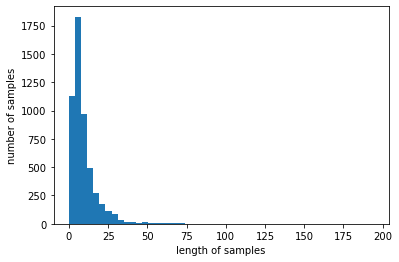

In [25]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [26]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

In [27]:
# 가장 긴 길이로 맞추기
X_data = pad_sequences(X_data, maxlen = maxlen)

# 학습 과정

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import tensorflow.keras.metrics 
from keras import backend as K
from sklearn.model_selection import KFold

### 교차 검증 적용

In [29]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

In [ ]:
# size = 1000000
# model = Sequential()
# model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
# model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
# model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
# num_of_class = 3 #클래스는 우선 4개로 분류함
# model.add(Dense(num_of_class, activation='linear'))
# ##model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
# model.summary()

size = 1000000

kfold = KFold(n_splits= 5, shuffle = True)

for train, test in kfold.split(X_data, Y_data):
    model = Sequential()
    model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
    num_of_class = 3 #클래스는 우선 4개로 분류함
    model.add(Dense(num_of_class, activation='linear'))
    ##model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=["accuracy",f1,precision, recall])
    es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
    check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)
    
    hist = model.fit(X_data, y_data, batch_size = 16, epochs=10, callbacks=[es, check_point])

Epoch 1/10
 32/325 [=>............................] - ETA: 6:21 - loss: 6.2008 - accuracy: 0.3221 - f1: 0.1096 - precision: 4684899.8828 - recall: 0.0548

## 모델 학습

In [ ]:
X_result = model.predict(X_test, batch_size = 16)
X_result

# OpenMax

In [ ]:
class_result = []
for a,b,c in X_result:
    numbers = [a,b,c]
    class_result.append(numbers.index(max(numbers)))
    
tf_result = (y_test == class_result)

for_open_max_0 = []; 
for_open_max_1 = [];
for_open_max_2 = [];

for i in range(len(class_result)):
    if(tf_result[i] == True):
        if(class_result[i] == 0):
            for_open_max_0.append(X_result[i])
        if(class_result[i] == 1):
            for_open_max_1.append(X_result[i])
        if(class_result[i] == 2):
            for_open_max_2.append(X_result[i])

## 평균 Logit Vector 계산

In [ ]:
def average_vector(for_open_max, class_result):
    a1=0
    a2=0
    a3=0
    for i in for_open_max:
        a1 += i[0]
        a2 += i[1]
        a3 += i[2]
    length = len(class_result)
    average = [a1/length, a2/length, a3/length]
    return average

average_0 = average_vector(for_open_max_0, class_result) #평균 Logit Vector - Class 0
average_1 = average_vector(for_open_max_1, class_result) #평균 Logit Vector - Class 1
average_2 = average_vector(for_open_max_2, class_result) #평균 Logit Vector - Class 2

## Distance 계산

In [ ]:
def distance(for_open_max, average):
    dist = []
    for i in for_open_max:
        m = i - average
        distance = (m[0]**2) + (m[1]**2) + (m[2]**2)
        dist.append(distance)
    return dist

dist0 = distance(for_open_max_0, average_0)
dist1 = distance(for_open_max_1, average_1)
dist2 = distance(for_open_max_2, average_2)

dist0.sort(reverse =True)
dist1.sort(reverse =True)
dist2.sort(reverse =True)

In [ ]:
# Distance 상위 20개 추출
maxdist0=[]
maxdist1=[]
maxdist2=[]
for i in range(0,20):
    maxdist0.append(dist0[i])
for j in range(0,20):
    maxdist1.append(dist1[j])
for k in range(0,20):
    maxdist2.append(dist2[k])

In [ ]:
#극단 분포 도구
import scipy.stats as s
import matplotlib.pyplot as plt

#def weib(x,n,a):
#    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)
def weib(x,n,a):
    return 1-np.exp[-(x / n)**a]

In [ ]:
# 0 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc, scale) = s.exponweib.fit_loc_scale(maxdist0, 1, 1)
print(loc, scale)

plt.plot(maxdist0, s.exponweib.cdf(maxdist0, *s.exponweib.fit(maxdist0, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist0, bins=np.linspace(0, 16, 33), alpha=0.5);
plt.show()

In [ ]:
# 1 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc, scale) = s.exponweib.fit_loc_scale(maxdist1, 1, 1)
print(loc, scale)

plt.plot(maxdist1, s.exponweib.cdf(maxdist1, *s.exponweib.fit(maxdist1, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist1, bins=np.linspace(0, 16, 33), alpha=0.5);
plt.show()

In [ ]:
# 2 라벨 Distance 추출 Weibull 극단 분포 CDF
(loc, scale) = s.exponweib.fit_loc_scale(maxdist2, 1, 1)
print(loc, scale)

plt.plot(maxdist2, s.exponweib.cdf(maxdist2, *s.exponweib.fit(maxdist2, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist2, bins=np.linspace(0, 16, 33), alpha=0.5);
plt.show()

## Softmax Layer 통과

In [ ]:
model2 = Sequential()
model2.add(Dense(num_of_class + 1, activation = 'softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])

In [ ]:
model2.fit(X_result, y_test, batch_size = 16)

In [ ]:
model2.predict(X_result, batch_size = 16)

## 결과 확인

In [ ]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test
result["Classification Result"] = class_result
result["Final Result"] = (y_test == class_result)

result.to_csv("test_result.csv")

In [ ]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 모델 저장

In [ ]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')

In [ ]:
##모델 조정이 끝나면, Model을 사용 하여 OpenMax에 필요한 자료를 선정하여 OpenMax로 구현할 예정입니다.